# 프로젝트: 한영 번역기 만들기

In [1]:
import requests
import tarfile

import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io

from konlpy.tag import Mecab

2024-12-20 15:17:23.939418: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Step 1. 데이터 다운로드

In [2]:
# # 다운로드할 파일의 URL
# url = "https://raw.githubusercontent.com/jungyeul/korean-parallel-corpora/master/korean-english-news-v1/korean-english-park.train.tar.gz"

# # 파일을 저장할 경로
# filename = "korean-english-park.train.tar.gz"

# # 파일 다운로드
# response = requests.get(url)
# with open(filename, 'wb') as file:
#     file.write(response.content)

# print(f"{filename} 파일이 성공적으로 다운로드되었습니다.")

# # 파일 경로
# file_name = "korean-english-park.train.tar.gz"

# # 압축 해제 및 추출
# with tarfile.open(file_name, "r:gz") as tar:
#     tar.extractall()  # 현재 디렉토리에 파일을 추출
#     print(f"{file_name} 파일이 성공적으로 추출되었습니다.")

In [3]:
kor_path = 'data/macine_translate/korean-english-park.train.ko'
eng_path = 'data/macine_translate/korean-english-park.train.en'

with open(kor_path, 'r') as f:
    kor = f.read().splitlines()
    
with open(eng_path, 'r') as f:
    eng = f.read().splitlines()
    
print(f"한국어 데이터 개수: {len(kor)}")
print(f"영어 데이터 개수: {len(eng)}")

한국어 데이터 개수: 94123
영어 데이터 개수: 94123


## Step 2. 데이터 정제 

set 데이터형이 중복을 허용하지 않는다는 것을 활용해 중복된 데이터를 제거하도록 합니다. 데이터의 병렬 쌍이 흐트러지지 않게 주의하세요! 중복을 제거한 데이터를 cleaned_corpus 에 저장합니다.

In [4]:
# set()을 사용하여 중복을 제거한 뒤 다시 리스트로 변환

cleaned_corpus = list(set(zip(kor, eng)))

print(f"전체 문장 쌍의 개수: {len(cleaned_corpus)}")

# 한국어 list
cleaned_kor = []
# 영어 list
cleaned_eng = []

for kor, eng in cleaned_corpus:
    cleaned_kor.append(kor)
    cleaned_eng.append(eng)
    
print(f"한국어: {cleaned_kor[100]}")
print(f"영어: {cleaned_eng[100]}")


전체 문장 쌍의 개수: 78968
한국어: 쓰촨성 대지진 전에 그 외 150여마리가 월롱현 판다 보호지역에 야생으로 살고 있었으나 연구진은 야생 판다 중 몇 마리가 지진에 살아 남았는지 확실하지 않다고 밝혔다.
영어: Another 150 wild pandas lived on the Wolong reserve before the quake struck, but researchers say it¡¯s unclear how many of the wild pandas survived.


데이터 확인

In [5]:
print(cleaned_kor[10000])
print(cleaned_eng[10000])

영국군 대변인은 미군 폭격기와 영국 포병이 29일 바스라의 마흐디 민병대 거점지역을 공격했다고 전했다.
U.S. warplanes and British artillery struck targets in Basra on Saturday, a British spokesman said.


In [6]:
print(cleaned_kor[9709])
print(cleaned_eng[9709])

특히 미국의 오래된 도시들은 계속 줄어들고 있어 사회적, 인종적인 문제를 낳게 될 것이다.
Old cities, especially in America, will continue to decline, creating social and racial problems.


In [7]:
print(cleaned_kor[1000:1005])
print(cleaned_eng[1000:1005])

['소말리아에서 노예 밀매 실태에 대한 TV 다큐멘터리를 제작하다 피랍됐던 프랑스 기자는 무장단체가 여자친구와의 휴대폰 통화를 허락했다며 건강은 괜찮은 편이라고 밝혔다.', '그는 또한 98년 인질 4명이 살해된 예멘 공격에 연루되어 있다.', '이번 사태는 서투른 계획과 준비과정에 있어서의 자금부족, 정부의 선전미숙에 따른 오해 등이 빚어낸 결과로 보여지며 여권 관리 사무실을 파괴한 허리케인 카트리나의 영향도 무시할 수 없다.', '병원은 구토와 미열로 치료를 받고 있는 환자들로 북적이면서 추가 병실을 운영하고 있으며 치료 중 일부 환자들이 사망했다.', '경찰은 지난 7월 5일(현지시간) 한밤중에 해변에서 미셀 파머(36)와 빈센트 애코스(34)를 체포해 추교(醜交), 외설죄, 공공장소 만취로 구속했다.']
['A French journalist kidnapped while producing a television documentary about human trafficking in Somalia said he is "quite okay," and has been allowed to use a mobile phone to talk to his girlfriend in France, according to a short phone interview he gave to a Somali journalist.', 'He is also linked to a 1998 attack in Yemen in which four hostages were killed.', 'The culprits have variously been identified as inept planning, underfunded preparations, popular misunderstanding of poorly crafted government advertising, unanticipated effects of public debate over immigration, tardy and ill-co

앞서 정의한 preprocessing() 함수는 한글에서는 동작하지 않습니다. 한글에 적용할 수 있는 정규식을 추가하여 함수를 재정의하세요!

In [8]:
# preprocess() 함수를 정의

def kor_prerocess_sentence(sentence):
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^가-힣?.!,]+", " ", sentence)
    sentence = sentence.strip()

    return sentence


def eng_prerocess_sentence(sentence, s_token=False, e_token=False):
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
    
    sentence = sentence.strip()
    
    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
        
    return sentence

In [9]:
# 형태소 분석기
mecab = Mecab()

# 토큰화 후 40개 이하의 문장만 필터링
kor_corpus = []
eng_corpus = []

for kor, eng in zip(cleaned_kor, cleaned_eng):
    kor_preprocessed = kor_prerocess_sentence(kor)
    kor_tokens = mecab.morphs(kor_preprocessed)

    # 영어 문장 전처리 및 토큰화
    eng_preprocessed = eng_prerocess_sentence(eng, s_token=True, e_token=False)
    eng_tokens = eng_preprocessed.split()
    # 토큰 길이가 max_len 이하인 문장만 추가
    if len(kor_tokens) <= 40 and len(eng_tokens) <= 40:
        kor_corpus.append(kor_tokens)
        eng_corpus.append(eng_tokens)

print(f"Filtered 문장 쌍 개수: {len(kor_corpus)}")
print(f"Filtered 문장 쌍 개수: {len(eng_corpus)}")

Filtered 문장 쌍 개수: 63736
Filtered 문장 쌍 개수: 63736


In [10]:
kor_corpus

[['이',
  '로써',
  '디',
  '다',
  '골키퍼',
  '는',
  '다음',
  '달',
  '열리',
  '는',
  '샤크',
  '타르',
  '도네츠크',
  '와',
  '의',
  '챔피언',
  '스리',
  '그',
  '조별',
  '예선',
  '경기',
  '에',
  '출전',
  '할',
  '수',
  '있',
  '게',
  '됐',
  '다',
  '.'],
 ['국가',
  '보안법',
  '은',
  '북한',
  '에',
  '대한',
  '호감',
  '을',
  '표현',
  '할',
  '경우',
  '중증',
  '처벌',
  '을',
  '받',
  '도록',
  '되',
  '어',
  '있',
  '는',
  '법',
  '이',
  '다',
  '.'],
 ['미국',
  '연예',
  '전문지',
  '인터',
  '테',
  '인',
  '먼',
  '트',
  '위클리',
  '는',
  '코디',
  '를',
  '할리우드',
  '에서',
  '가장',
  '유능',
  '한',
  '인물',
  '명',
  '중',
  '위',
  '에',
  '올렸',
  '다',
  '.'],
 ['기사', '공유'],
 ['트리뷴',
  '지',
  '의',
  '편집국',
  '은',
  '위기',
  '의',
  '순간',
  '에',
  '미국',
  '을',
  '이끌',
  '고',
  '나라',
  '의',
  '목적',
  '에',
  '대한',
  '상식',
  '을',
  '되찾',
  '아',
  '줄',
  '최고',
  '의',
  '후보',
  '는',
  '오바마',
  '라고',
  '말',
  '했',
  '습니다',
  '.'],
 ['아시아',
  '는',
  '무서운',
  '속도',
  '로',
  '산업',
  '과',
  '경제',
  '를',
  '발전',
  '시키',
  '고',
  '있',
  '으며',
  ',',
  '동시',
  '에',
  '

## Step 3. 데이터 토큰화

앞서 정의한 tokenize() 함수를 사용해 데이터를 텐서로 변환하고 각각의 tokenizer를 얻으세요! 단어의 수는 실험을 통해 적당한 값을 맞춰주도록 합니다! (최소 10,000 이상!)

❗ 주의: 난이도에 비해 데이터가 많지 않아 훈련 데이터와 검증 데이터를 따로 나누지는 않습니다.

In [11]:
def kor_tokenizer(corpus):
    # mecab = Mecab()
    # 형태소 분석기를 활용한 토큰화
    # tokenized_corpus = [mecab.morphs(sentence) for sentence in corpus]
    tokenized_corpus = corpus
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(tokenized_corpus)
    
    tensor = tokenizer.texts_to_sequences(tokenized_corpus)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    
    return tensor, tokenizer

def eng_tokenizer(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)
    
    tensor = tokenizer.texts_to_sequences(corpus)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    
    return tensor, tokenizer

In [12]:
# tokenize
kor_tensor, kor_tokenizer = kor_tokenizer(kor_corpus)
eng_tensor, eng_tokenizer = eng_tokenizer(eng_corpus)

print(kor_tensor.shape)
print(eng_tensor.shape)

(63736, 40)
(63736, 40)


In [13]:
print(len(kor_tokenizer.index_word))
print(len(eng_tokenizer.index_word))

37338
38791


## Step 4. 모델 설계

한국어를 영어로 잘 번역해 줄 멋진 Attention 기반 Seq2seq 모델을 설계하세요! 앞서 만든 모델에 Dropout 모듈을 추가하면 성능이 더 좋아집니다! Embedding Size와 Hidden Size는 실험을 통해 적당한 값을 맞춰 주도록 합니다!

In [14]:
# attention - BahdanauAttention
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units, dropout_rate=0.5):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)
        attn = self.dropout(attn) # dropout
        
        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

In [15]:
# encoder
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, dropout_rate=0.5):
        super(Encoder, self).__init__()
        
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.dropout(out) # dropout
        out = self.gru(out)
        out = self.dropout(out) # dropout
         
        return out

In [16]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, dropout_rate=0.5):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.attention = BahdanauAttention(self.dec_units)
        

    def call(self, x, h_dec, enc_out):
        """
        x: Decoder의 input token [batch x 1]
        h_dec: Decoder의 이전 hidden state [batch x units]
        enc_out: Encoder의 output sequence [batch x length x units]
        """
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = self.dropout(out)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        out, h_dec = self.gru(out)
        out = self.dropout(out) # dropout
        out = tf.reshape(out, (-1, out.shape[2])) # [batch x length x units] -> [batch x units]
        out = self.fc(out)
        out = self.dropout(out) # dropout

        return out, h_dec, attn

In [17]:
BATCH_SIZE     = 32
SRC_VOCAB_SIZE = len(kor_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(eng_tokenizer.index_word) + 1

units         = 1024
embedding_dim = 256

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units) 

# sample input
sequence_len = 40

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

2024-12-20 15:17:40.265605: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9621 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:19:00.0, compute capability: 7.5
2024-12-20 15:17:40.266239: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9621 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5
2024-12-20 15:17:40.266786: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 9621 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:67:00.0, compute capability: 7.5
2024-12-20 15:17:40.267303: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 9604 MB memory:  -> device: 3, name: NVIDIA GeForce RTX

Encoder Output: (32, 40, 1024)
Decoder Output: (32, 38792)
Decoder Hidden State: (32, 1024)
Attention: (32, 40, 1)


## Step 5. 훈련하기

In [18]:
# optimizer & loss
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

In [19]:
@tf.function # 훈련을 위한 함수를 컴파일
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape: # tf.GradientTape()는 가중치 갱신을 위한 Gradient를 자동 미분으로 계산
        enc_out = encoder(src) # Encoder에 소스 문장을 전달하면 컨텍스트 벡터인 enc_out을 리턴
        h_dec = enc_out[:, -1] # Encoder의 마지막 time step의 hidden state를 Decoder의 첫번째 hidden state로 사용
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1) # Decoder에 입력으로 전달할 <start> 토큰 생성

        for t in range(1, tgt.shape[1]): # 타겟 문장의 길이만큼 반복
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out) # enc_out, hidden state를 기반으로 다음 단어(t시점의 입력)를 예측
 
            loss += loss_function(tgt[:, t], pred) # 타겟 단어와 예측 단어로 손실을 계산
            dec_src = tf.expand_dims(tgt[:, t], 1) # t 시점의 타겟 문장을 다음 시점의 Decoder 입력으로 사용
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [20]:
def translate(sentence, encoder, decoder, kor_tokenizer, eng_tokenizer, max_length=30):
    sentence = kor_prerocess_sentence(sentence)  # 전처리
    mecab = Mecab()
    tokenized_sentence = mecab.morphs(sentence)  
    tensor = kor_tokenizer.texts_to_sequences([tokenized_sentence])  
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')  # 패딩

    enc_out = encoder(tensor)
    h_dec = enc_out[:, -1]  # Encoder의 마지막 hidden state

    # Decoder에 <start> 토큰 입력
    dec_src = tf.expand_dims([eng_tokenizer.word_index['<start>']], 1)
    result = []  # 번역 결과 저장

    for i in range(max_length):
        pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)
        pred_id = tf.argmax(pred, axis=-1).numpy().flatten()[0]

        if eng_tokenizer.index_word[pred_id] == '<end>':
            break

        result.append(eng_tokenizer.index_word[pred_id])

        dec_src = tf.expand_dims([pred_id], 1) # 다음 시점의 Decoder 입력으로 사용

    return ' '.join(result)

In [21]:
from tqdm import tqdm  # tqdm
import random

EPOCHS = 10
src_list = ['오바마는 대통령이다.', '시민들은 도시 속에 산다.', '커피는 필요 없다.', '일곱 명의 사망자가 발생했다.']

for epoch in range(EPOCHS):
    total_loss = 0
    
    # 배치 인덱스 셔플
    idx_list = list(range(0, kor_tensor.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)  # tqdm으로 진행 상태 표시

    for (batch, idx) in enumerate(t):
        # 배치 데이터 추출 및 train_step 호출
        batch_loss = train_step(
            kor_tensor[idx:idx+BATCH_SIZE],
            eng_tensor[idx:idx+BATCH_SIZE],
            encoder,
            decoder,
            optimizer,
            eng_tokenizer
        )
        total_loss += batch_loss

        # tqdm 상태 업데이트
        t.set_description_str('Epoch %2d' % (epoch + 1))  # Epoch 정보
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))  # 평균 Loss

    # Epoch 종료 후 번역 결과 출력
    print(f"\nEpoch {epoch + 1} Loss: {total_loss / (batch + 1):.4f}")
    print("\n=== Epoch 번역 결과 ===")
    for sentence in src_list:
        translation = translate(sentence, encoder, decoder, kor_tokenizer, eng_tokenizer)
        print(f"소스 문장: {sentence}")
        print(f"번역 문장: {translation}")
    print("=========================\n")

  0%|          | 0/1992 [00:00<?, ?it/s]2024-12-20 15:18:16.527489: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f606848bad0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-20 15:18:16.527526: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2024-12-20 15:18:16.527533: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2024-12-20 15:18:16.527539: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (2): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2024-12-20 15:18:16.527545: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (3): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2024-12-20 15:18:16.532211: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env


Epoch 1 Loss: 4.1849

=== Epoch 번역 결과 ===
소스 문장: 오바마는 대통령이다.
번역 문장: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
소스 문장: 시민들은 도시 속에 산다.
번역 문장: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
소스 문장: 커피는 필요 없다.
번역 문장: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
소스 문장: 일곱 명의 사망자가 발생했다.
번역 문장: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .



Epoch  2: 100%|██████████| 1992/1992 [05:53<00:00,  5.64it/s, Loss 4.1860]



Epoch 2 Loss: 4.1860

=== Epoch 번역 결과 ===
소스 문장: 오바마는 대통령이다.
번역 문장: , , , , , , , , , , , , , , , , , , , , , , , , , , , , , ,
소스 문장: 시민들은 도시 속에 산다.
번역 문장: , , , , , , , , , , , , , , , , , , , , , , , , , , , , , ,
소스 문장: 커피는 필요 없다.
번역 문장: , , , , , , , , , , , , , , , , , , , , , , , , , , , , , ,
소스 문장: 일곱 명의 사망자가 발생했다.
번역 문장: , , , , , , , , , , , , , , , , , , , , , , , , , , , , , ,



Epoch  3: 100%|██████████| 1992/1992 [05:52<00:00,  5.65it/s, Loss 4.0945]



Epoch 3 Loss: 4.0945

=== Epoch 번역 결과 ===
소스 문장: 오바마는 대통령이다.
번역 문장: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
소스 문장: 시민들은 도시 속에 산다.
번역 문장: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
소스 문장: 커피는 필요 없다.
번역 문장: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
소스 문장: 일곱 명의 사망자가 발생했다.
번역 문장: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the



Epoch  4: 100%|██████████| 1992/1992 [05:52<00:00,  5.66it/s, Loss 4.0098]



Epoch 4 Loss: 4.0098

=== Epoch 번역 결과 ===
소스 문장: 오바마는 대통령이다.
번역 문장: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
소스 문장: 시민들은 도시 속에 산다.
번역 문장: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
소스 문장: 커피는 필요 없다.
번역 문장: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
소스 문장: 일곱 명의 사망자가 발생했다.
번역 문장: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the



Epoch  5: 100%|██████████| 1992/1992 [05:52<00:00,  5.66it/s, Loss 4.0128]



Epoch 5 Loss: 4.0128

=== Epoch 번역 결과 ===
소스 문장: 오바마는 대통령이다.
번역 문장: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
소스 문장: 시민들은 도시 속에 산다.
번역 문장: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
소스 문장: 커피는 필요 없다.
번역 문장: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
소스 문장: 일곱 명의 사망자가 발생했다.
번역 문장: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the



Epoch  6: 100%|██████████| 1992/1992 [05:52<00:00,  5.64it/s, Loss 3.9457]



Epoch 6 Loss: 3.9457

=== Epoch 번역 결과 ===
소스 문장: 오바마는 대통령이다.
번역 문장: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
소스 문장: 시민들은 도시 속에 산다.
번역 문장: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
소스 문장: 커피는 필요 없다.
번역 문장: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
소스 문장: 일곱 명의 사망자가 발생했다.
번역 문장: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the



Epoch  7: 100%|██████████| 1992/1992 [05:52<00:00,  5.65it/s, Loss 3.8278]



Epoch 7 Loss: 3.8278

=== Epoch 번역 결과 ===
소스 문장: 오바마는 대통령이다.
번역 문장: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
소스 문장: 시민들은 도시 속에 산다.
번역 문장: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
소스 문장: 커피는 필요 없다.
번역 문장: . the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
소스 문장: 일곱 명의 사망자가 발생했다.
번역 문장: the the . the the . the the . the the . the the . the the . the the . the the . the the . the the .



Epoch  8: 100%|██████████| 1992/1992 [05:52<00:00,  5.65it/s, Loss 3.7423]



Epoch 8 Loss: 3.7423

=== Epoch 번역 결과 ===
소스 문장: 오바마는 대통령이다.
번역 문장: the . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
소스 문장: 시민들은 도시 속에 산다.
번역 문장: , the . , the . , the . , the . , the . , the . , the . , the . , the . , the .
소스 문장: 커피는 필요 없다.
번역 문장: , the a a a a a a a a a a a a a a a a a a a a a a a a a a a a
소스 문장: 일곱 명의 사망자가 발생했다.
번역 문장: the . , the . , the . , the . , the . , the . , the . , the . , the . , the . ,



Epoch  9: 100%|██████████| 1992/1992 [05:52<00:00,  5.65it/s, Loss 3.6849]



Epoch 9 Loss: 3.6849

=== Epoch 번역 결과 ===
소스 문장: 오바마는 대통령이다.
번역 문장: the . , the . , the . , the . , the . , the . , the . , the . , the . , the . ,
소스 문장: 시민들은 도시 속에 산다.
번역 문장: the united be the united be the united be the united be the united be the united be the united be the united be the united be the united be
소스 문장: 커피는 필요 없다.
번역 문장: the . , the years . , the years . , the years . , the years . , the years . , the years . , the years .
소스 문장: 일곱 명의 사망자가 발생했다.
번역 문장: the united be the united be the united be the united be the united be the united be the united be the united be the united be the united be



Epoch 10: 100%|██████████| 1992/1992 [05:52<00:00,  5.65it/s, Loss 3.6261]



Epoch 10 Loss: 3.6261

=== Epoch 번역 결과 ===
소스 문장: 오바마는 대통령이다.
번역 문장: the . the . the . the . the . the . the . the . the . the . the . the . the . the . the .
소스 문장: 시민들은 도시 속에 산다.
번역 문장: the military . the president , the president , the president , the president , the president , the president , the president , the president , the president ,
소스 문장: 커피는 필요 없다.
번역 문장: the . the . the . the . the . the . the . the . the . the . the . the . the . the . the .
소스 문장: 일곱 명의 사망자가 발생했다.
번역 문장: the security , the security , the security , the security , the security , the security , the security , the security , the security , the security ,



/tmp/ipykernel_71450/1922092114.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_71450/1922092114.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
/home/mjun/.conda/envs/pp/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/mjun/.conda/envs/pp/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 44273 (\N{HANGUL SYLLABLE GOB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
findfont: Font family 'NanumBarunGothic' not found.
/home/mjun/.conda/envs/pp/lib/python3.8/site-packages/IPython/core/py

원문: 일곱 명의 사망자가 발생했다.
번역문: the security , the security , the security , the security , the security , the security , the security , the security , the security , the security ,


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

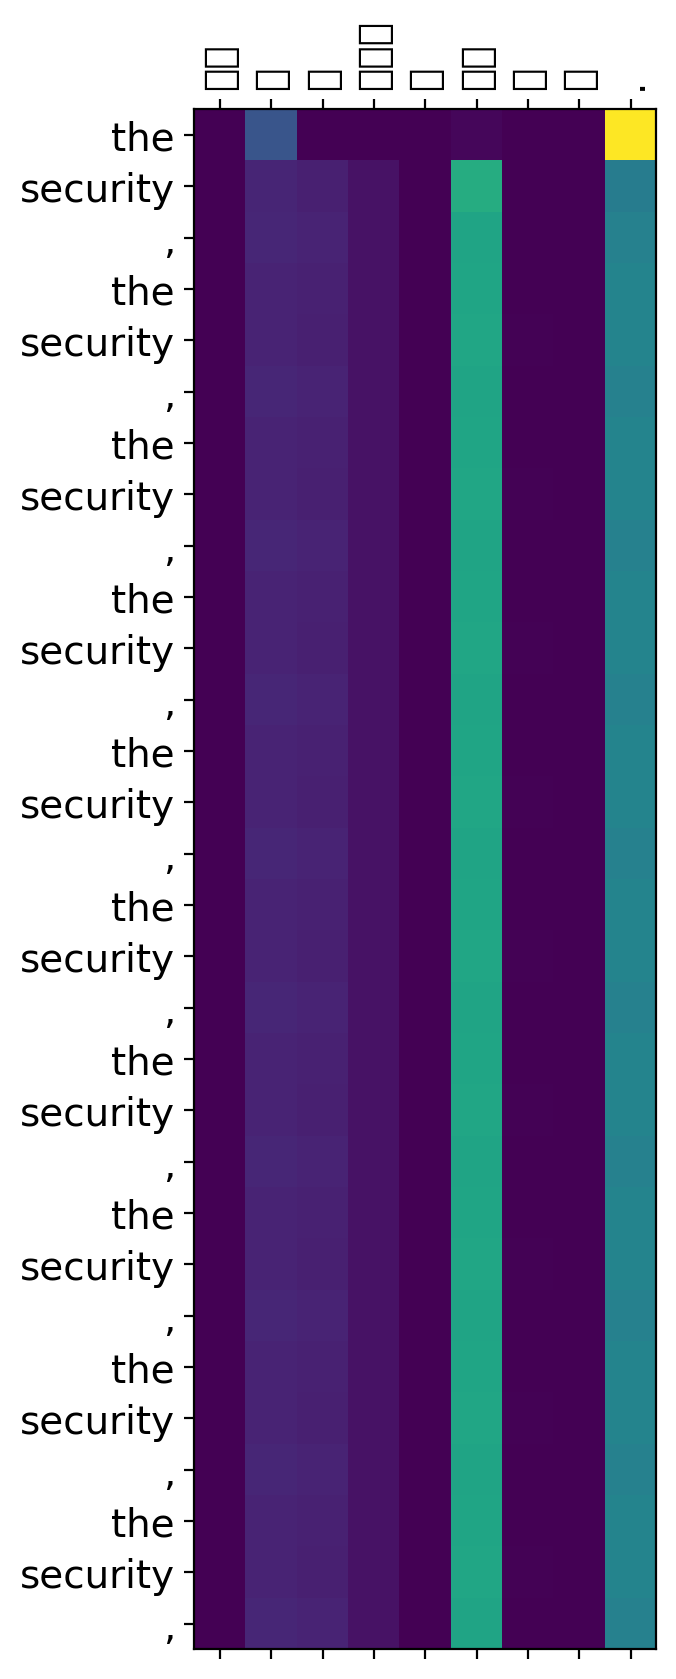

In [33]:
# Attention Map 예문 시각화
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

# plot_attention() 함수를 사용하여 번역후 시각화
def translate(sentence, encoder, decoder):
    sentence = kor_prerocess_sentence(sentence)
    mecab = Mecab()
    tokenized_sentence = mecab.morphs(sentence)
    tensor = kor_tokenizer.texts_to_sequences([tokenized_sentence])
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    enc_out = encoder(tensor)
    h_dec = enc_out[:, -1]

    dec_src = tf.expand_dims([eng_tokenizer.word_index['<start>']], 1)
    result = []

    # attention 크기 동적 초기화
    max_input_length = len(tokenized_sentence)
    max_output_length = 30
    attention = np.zeros((max_output_length, max_input_length))

    for i in range(max_output_length):
        pred, h_dec, attn = decoder(dec_src, h_dec, enc_out)
        pred_id = tf.argmax(pred, axis=-1).numpy().flatten()[0]

        if eng_tokenizer.index_word[pred_id] == '<end>':
            break

        result.append(eng_tokenizer.index_word[pred_id])

        dec_src = tf.expand_dims([pred_id], 1)

        # attention 크기 동적으로 조정
        attention[i, :attn.numpy().shape[1]] = attn.numpy().reshape(-1)
    
    return result, attention[:len(result), :max_input_length]

sentence = "일곱 명의 사망자가 발생했다."
result, attention = translate(sentence, encoder, decoder)
print("원문:", sentence)
print("번역문:", ' '.join(result))
plot_attention(attention, mecab.morphs(sentence), result)